<center><h1>Deep learing project no.1</h1></center>

<h3>Authors:</h3>
<p>Marek Szydłowski 136633 <br/>
Wotjek Tomczak 145467<p>

In [32]:
%matplotlib inline
import os
import json
import fnmatch

from pathlib import Path

from IPython.display import display

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import gdown

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]

<center><h1>Part 1.</h1></center>

<center><h1>Downloading the data</h1></center>

In [33]:
DATA_DIR = "data/"
DATA_PATH = DATA_DIR + "101_ObjectCategories/"
DATA_TAR = DATA_DIR + "101_ObjectCategories.tar.gz"
MODELS_PATH = "models/"

BACKGROUND_GOOGLE = DATA_PATH + "BACKGROUND_Google"


In [34]:
data_check = Path(DATA_PATH)
tar_check = Path(DATA_TAR)

!mkdir -p $DATA_DIR

if not data_check.exists() and not tar_check.exists():
    # No data exists
    gdown.download("https://drive.google.com/uc?id=194fJtjdnJUsH6qDdOmMAgnbBcHcVWwgT", DATA_DIR, False)

if tar_check.exists():
    # Extract and remove tar.gz file
    !tar -xf $DATA_TAR --directory="data"
    !rm -r $BACKGROUND_GOOGLE
    !rm $DATA_TAR


<center><h1>Data preprocessing</h1></center>

In [35]:
# cheking size of classes in our database of choice

file_counter = []

for data_dir in Path(DATA_PATH).iterdir():
    file_counter.append(
        [
            len(fnmatch.filter(os.listdir(data_dir), "*.jpg")),
            str(data_dir).split("/")[-1],
        ]
    )

results = pd.DataFrame(
    sorted(file_counter, key=lambda x: x[0], reverse=True),
    columns=["FILE_COUNT", "CLASS_NAME"],
)

results


,FILE_COUNT,CLASS_NAME
0,800,airplanes
1,798,Motorbikes
2,435,Faces
3,435,Faces_easy
4,239,watch
...,...,...
96,34,platypus
97,34,wild_cat
98,33,binocular
99,32,metronome


In [36]:
classes = results[results["FILE_COUNT"] > 80]["CLASS_NAME"].values
max_len = np.min(results[results["FILE_COUNT"] > 80]["FILE_COUNT"])


In [37]:
classes


array(['airplanes', 'Motorbikes', 'Faces', 'Faces_easy', 'watch',
       'Leopards', 'bonsai', 'car_side', 'ketch', 'chandelier',
       'hawksbill', 'grand_piano', 'brain', 'butterfly', 'helicopter',
       'menorah', 'kangaroo', 'starfish', 'trilobite', 'buddha', 'ewer',
       'sunflower', 'scorpion', 'revolver', 'laptop'], dtype=object)

In [38]:
images = {}
for data_dir in Path(DATA_PATH).iterdir():
    if data_dir.name in classes:
        current_len = 0
        for f in data_dir.iterdir():
            if current_len == max_len:
                break

            if not f.is_file():
                continue

            current_len += 1

            if data_dir.name not in images:
                images[data_dir.name] = 1
            else:
                images[data_dir.name] += 1

df = (
    pd.DataFrame.from_dict(images, "index")
    .reset_index()
    .rename({0: "length", "index": "name"}, axis=1)
)


In [39]:
df


,name,length
0,Faces,81
1,Faces_easy,81
2,Leopards,81
3,Motorbikes,81
4,airplanes,81
5,bonsai,81
6,brain,81
7,buddha,81
8,butterfly,81
9,car_side,81


In [40]:
dataset = []
labels = []
filenames = []

for row in df.itertuples():
    dirname = row.name
    max_len = row.length

    current_len = 0
    for filename in os.listdir(DATA_PATH + dirname):
        if current_len == max_len:
            break

        if ".jpg" not in filename:
            continue

        current_len += 1

        img = cv2.imread(DATA_PATH + dirname + "/" + filename)
        resized = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)

        filenames.append(dirname + "/" + filename)
        dataset.append(resized)
        labels.append(dirname)

dataset = np.array(dataset)


In [41]:
dataset.shape


(2025, 64, 64, 3)

In [42]:
bgr_mean = np.mean(dataset, axis=(0, 1, 2))
bgr_std = np.std(dataset, axis=(0, 1, 2))
bgr_mean, bgr_std


(array([123.95332875, 132.96645978, 137.9144864 ]),
 array([80.14290487, 76.34923509, 78.34238172]))

In [43]:
std_data = (dataset - bgr_mean) / bgr_std
std_data.shape


(2025, 64, 64, 3)

Image before standardization


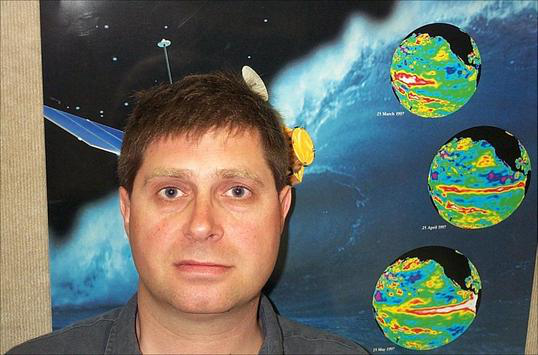

In [44]:
print("Image before standardization")
with Image.open(DATA_PATH + filenames[0]) as img:
    display(img)


In [45]:
# # DO NOT CLOSE IMAGE WITH "X" ICON, JUST WAIT
# # Uncoment to run


# cv2.imshow('tmp', std_data[0])
# cv2.waitKey(7000)

# cv2.destroyAllWindows()


<center><h1>Splitting data into Train and Test</h1></center>

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    std_data, list(zip(labels, filenames)), stratify=labels, test_size=0.3, random_state=23
)

y_train, y_test = np.array(y_train), np.array(y_test)

y_train, train_fnames = y_train[:, 0], y_train[:, 1]
y_test, test_fnames = y_test[:, 0], y_test[:, 1]


In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1417, 64, 64, 3), (608, 64, 64, 3), (1417,), (608,))

In [48]:
def oneHotterEncoder(target):
    _target = target.reshape(-1, 1)
    encoder = OneHotEncoder(handle_unknown="ignore")
    new_target = encoder.fit(_target)
    return new_target.categories_, new_target.transform(_target).toarray()


In [49]:
classes_train, y_train_enc = oneHotterEncoder(y_train)
classes_test, y_test_enc = oneHotterEncoder(y_test)

(classes_train,) = classes_train
(classes_test,) = classes_test


<center><h1>Model definition and training</h1></center>

In [50]:
def create_and_solve_model(
    isDropout=True,
    drop_1=0.75,
    drop_2=0.65,
    activation="relu",
    isBatchNormalization=True,
    pooling=layers.MaxPool2D,
    no_conv_layers=2,
    batch_size=32,
    verbose=False,
):
    """Helper function for all experiments with tasks."""

    model = models.Sequential()

    model.add(
        layers.Conv2D(
            32,
            (3, 3),
            activation=activation,
            padding="same",
            input_shape=X_train[0].shape,
        )
    )
    model.add(pooling((2, 2)))

    for i in range(no_conv_layers):
        model.add(layers.Conv2D(64, (3, 3), activation=activation, padding="same"))
        if i != no_conv_layers - 1:
            model.add(pooling((2, 2)))

    if isBatchNormalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Flatten())

    if isDropout:
        model.add(layers.Dropout(drop_1))

    model.add(layers.Dense(64))

    if isDropout:
        model.add(layers.Dropout(drop_2))

    model.add(layers.Dense(64))
    model.add(layers.Dense(len(classes), activation="softmax"))

    if verbose:
        print(f"Number of classes: {len(classes)}")
        model.summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=5)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    history = model.fit(
        X_train,
        y_train_enc,
        batch_size=batch_size,
        epochs=250,
        validation_data=(X_test, y_test_enc),
        callbacks=[early_stopping],
        use_multiprocessing=True,
        verbose=verbose,
    )

    params = {
        "isDropout": isDropout,
        "drop_1": drop_1,
        "drop_2": drop_2,
        "activation": activation,
        "isBatchNormalization": isBatchNormalization,
        "pooling": pooling,
        "no_conv_layers": no_conv_layers,
        "batch_size": batch_size,
    }

    return model, history, params


In [51]:
def plot_model_accuracy(history: dict):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(history["accuracy"], label="accuracy")
    ax1.plot(history["val_accuracy"], label="val_accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title('Accuracy')
    ax1.set_ylim([0.5, 1])
    ax1.legend(loc="lower right")
    
    ax2.plot(history["loss"], label="loss")
    ax2.plot(history["val_loss"], label="val_loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title('Loss')
    ax2.legend(loc="lower right")
    
    fig.suptitle('Model accuracy and loss')
    plt.show()

In [52]:
def display_confusion_matrix(model):
    y_pred = np.argmax(model.predict(X_test), axis=1)

    tmp = []
    for item in y_test:
        tmp.append(np.where(classes_test == item))

    y_true = np.array(tmp).reshape(y_pred.shape)

    prec, rec, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    for ind in range(len(prec)):
        print(
            f"Class {ind}:\tPrecision: {round(prec[ind], 3):<10}"
            f"Recall: {round(rec[ind], 3):<10}"
            f"F-score: {round(fscore[ind], 3):<10}"
        )

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    _ = disp.plot()



In [53]:
def print_update_test_acc(model, best_model=None):
    """Returns True if current acc is better, False otherwise"""
    _, test_acc = model.evaluate(X_test, y_test_enc, verbose=2)
    print(f"Test accuracy: {round(test_acc * 100, 3)}%\n")

    if best_model is None:
        return False

    _, best_acc = best_model.evaluate(X_test, y_test_enc, verbose=2)
    return test_acc * 1.05 > best_acc


In [54]:
def display_example_images(model):
    predict_val = model.predict(X_test)
    predict_class = np.argmax(predict_val, axis=1)
    
    tmp = classes_test[predict_class] == y_test
    
    correctly_classified = np.where(tmp == True)[0][0]
    incorrectly_classified = np.where(tmp == False)[0][0]

    for val_idx, phrase in zip([correctly_classified, incorrectly_classified], ['correctly', 'incorrectly']):
        if val_idx is not None:
            print(f'Photo {test_fnames[val_idx]} {phrase} classified as {classes_test[predict_class[val_idx]]}')
            with Image.open(DATA_PATH + test_fnames[val_idx]) as img:
                display(img)
            for class_no, class_prob in enumerate(predict_val[val_idx]):
                print(f'{f"Class {class_no} probability:":<24}{round(class_prob * 100, 3)}%')
        else:
            print(f'No {phrase} classified photo found')
        print('\n\n')

### To train one model randomly we would run the following line:

In [55]:
# model, history, params = create_and_solve_model(verbose=True)


In [56]:
def save_model(model, fname="model"):
    model.save(MODELS_PATH + fname)


def load_model(fname="model"):
    return tf.keras.models.load_model(MODELS_PATH + fname)

### Using Google Colab we've trained a lot of models and chose the best one saved as a "best_model"

In [57]:
model = load_model("best_model")
with open("best_model_history.json", 'r') as infile:
    history = json.load(infile)

Photo revolver/image_0052.jpg correctly classified as revolver


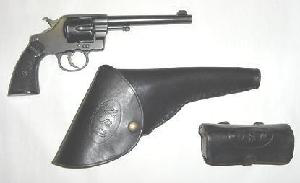

Class 0 probability:    0.0%
Class 1 probability:    0.0%
Class 2 probability:    0.0%
Class 3 probability:    0.0%
Class 4 probability:    0.0%
Class 5 probability:    0.0%
Class 6 probability:    0.0%
Class 7 probability:    0.0%
Class 8 probability:    0.0%
Class 9 probability:    0.0%
Class 10 probability:   0.0%
Class 11 probability:   0.0%
Class 12 probability:   0.0%
Class 13 probability:   0.0%
Class 14 probability:   0.0%
Class 15 probability:   0.0%
Class 16 probability:   0.0%
Class 17 probability:   0.0%
Class 18 probability:   0.0%
Class 19 probability:   99.993%
Class 20 probability:   0.001%
Class 21 probability:   0.001%
Class 22 probability:   0.0%
Class 23 probability:   0.0%
Class 24 probability:   0.003%



Photo butterfly/image_0023.jpg incorrectly classified as ketch


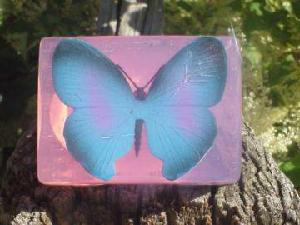

Class 0 probability:    0.901%
Class 1 probability:    0.01%
Class 2 probability:    0.0%
Class 3 probability:    0.0%
Class 4 probability:    0.001%
Class 5 probability:    0.0%
Class 6 probability:    0.014%
Class 7 probability:    1.3%
Class 8 probability:    5.469%
Class 9 probability:    0.0%
Class 10 probability:   0.651%
Class 11 probability:   0.05%
Class 12 probability:   0.0%
Class 13 probability:   0.002%
Class 14 probability:   0.0%
Class 15 probability:   3.419%
Class 16 probability:   87.158%
Class 17 probability:   0.01%
Class 18 probability:   0.981%
Class 19 probability:   0.002%
Class 20 probability:   0.005%
Class 21 probability:   0.013%
Class 22 probability:   0.004%
Class 23 probability:   0.006%
Class 24 probability:   0.002%





In [58]:
display_example_images(model)

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 257ms/epoch - 14ms/step
Test accuracy: 91.612%

Class 0:	Precision: 0.96      Recall: 1.0       F-score: 0.98      
Class 1:	Precision: 1.0       Recall: 1.0       F-score: 1.0       
Class 2:	Precision: 0.889     Recall: 1.0       F-score: 0.941     
Class 3:	Precision: 0.885     Recall: 0.958     F-score: 0.92      
Class 4:	Precision: 0.941     Recall: 0.667     F-score: 0.78      
Class 5:	Precision: 0.952     Recall: 0.833     F-score: 0.889     
Class 6:	Precision: 0.821     Recall: 0.92      F-score: 0.868     
Class 7:	Precision: 0.958     Recall: 0.92      F-score: 0.939     
Class 8:	Precision: 0.958     Recall: 0.92      F-score: 0.939     
Class 9:	Precision: 1.0       Recall: 1.0       F-score: 1.0       
Class 10:	Precision: 0.84      Recall: 0.875     F-score: 0.857     
Class 11:	Precision: 1.0       Recall: 0.875     F-score: 0.933     
Class 12:	Precision: 1.0       Recall: 0.84      F-score: 0.913     
Class 13:	Precisio

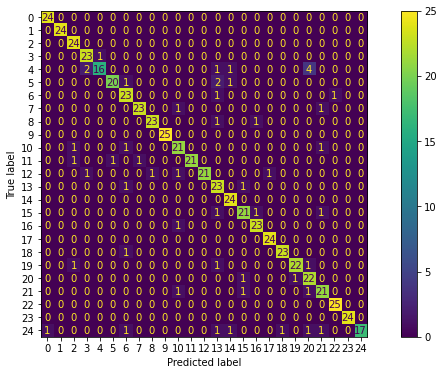

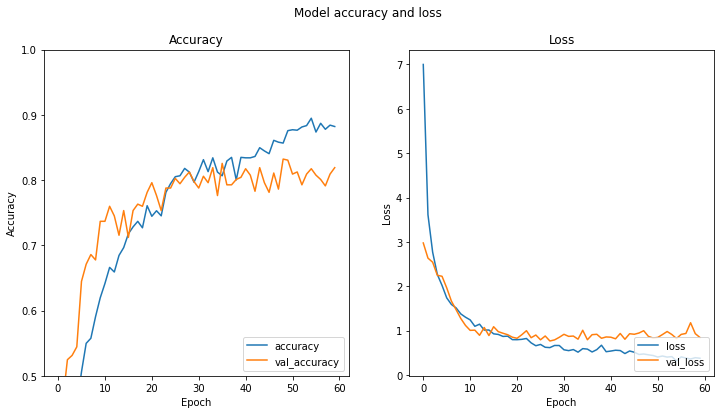

In [59]:
print_update_test_acc(model)
display_confusion_matrix(model)
plot_model_accuracy(history)

<center><h1>Saving model</h1></center>

In [60]:
!mkdir -p $MODELS_PATH 

model.save(MODELS_PATH + "model")

2021-11-18 14:30:00.660869: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model/assets


In [61]:
model_loaded = load_model()


In [62]:
# Predictions on loaded model
predicted = np.argmax(model_loaded.predict(X_test), axis=1)
print(f'Prediction on loaded model: {round((np.count_nonzero(y_test == classes_test[predicted]) / y_test.size) * 100, 3)}')

Prediction on loaded model: 91.612


In [63]:
model_loaded.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 64)      

<center><h1>Summary</h1></center>

- What results have you achieved?

Validation accuracy is pretty high. Running the trainign of the model couple of times gave us differing results - from as low as 75% to as high as 91% so we can say that on average it has above 80% of an accuracy.

- Is the underfitting or overfitting of the model visible? If so, what are your suggestions for solving this problem?

For this specific model we don't think there is any under or overfitting. We can see though that if we were to train it a bit longer (if we did not use early stopping) the model would overfit. Signs of it can be seen by looking at charts of accuract and loss. At the end val_accuracy (on validation set) seems like it starts to go down as well as its loss while accuracy and loss on training set is going up.

- Which class(es) the model had a problem with? Which it did best with? Which pair of classes were most often confused with each other? Can you guess why?

Our model has problem with classes 4 and 24. Recall for these classes has lowest values of respectively 0.667 and 0.708 meaning that in case of class 4 only 2/3 of cases are classified correctly and in case of class 24 - a bit above 70%. We think that it's pretty good result nonetheless.

- What improvement opportunities do you see?

We think that the data is a key problem in here and not a model architecture. Some of the training photos are of a poor quality.


<center><h1>Part 2.</h1></center>

In [76]:
# Initialize best model to our first model
params = {
    "isDropout": True,
    "drop_1": 0.75,
    "drop_2": 0.65,
    "activation": "relu",
    "isBatchNormalization": True,
    "pooling": layers.MaxPool2D,
    "no_conv_layers": 2,
    "batch_size": 32,
}

best_model = model
best_model_history = history
best_model_params = params


<center><h3>Task 3.</h3></center>

No dropouts:
19/19 - 0s - loss: 1.4752 - accuracy: 0.6908 - 224ms/epoch - 12ms/step
Test accuracy: 69.079%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 257ms/epoch - 14ms/step


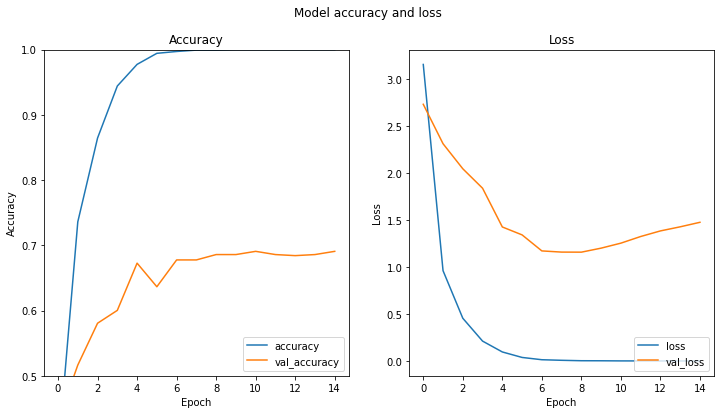



Model with dropout rates: 0.1
19/19 - 0s - loss: 1.8950 - accuracy: 0.6678 - 160ms/epoch - 8ms/step
Test accuracy: 66.776%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 170ms/epoch - 9ms/step


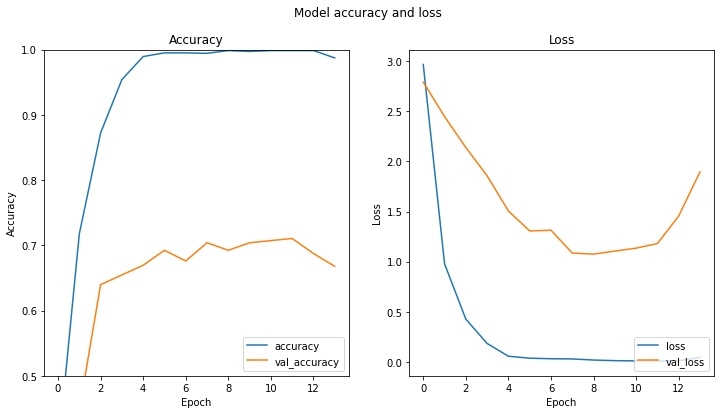



Model with dropout rates: 0.4
19/19 - 0s - loss: 1.3207 - accuracy: 0.7319 - 160ms/epoch - 8ms/step
Test accuracy: 73.191%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 174ms/epoch - 9ms/step


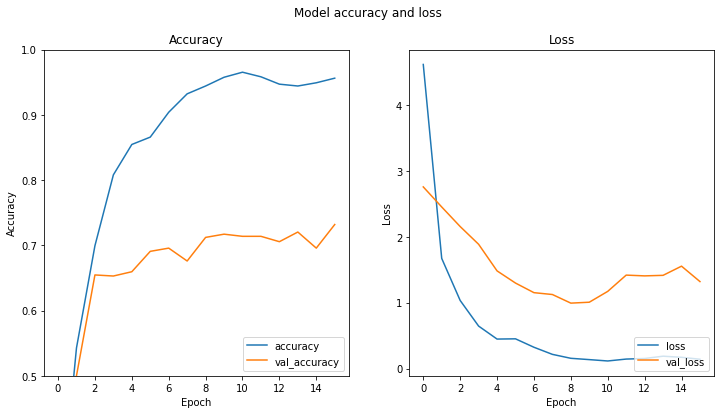



Model with dropout rates: 0.8
19/19 - 0s - loss: 0.6759 - accuracy: 0.8125 - 182ms/epoch - 10ms/step
Test accuracy: 81.25%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 177ms/epoch - 9ms/step


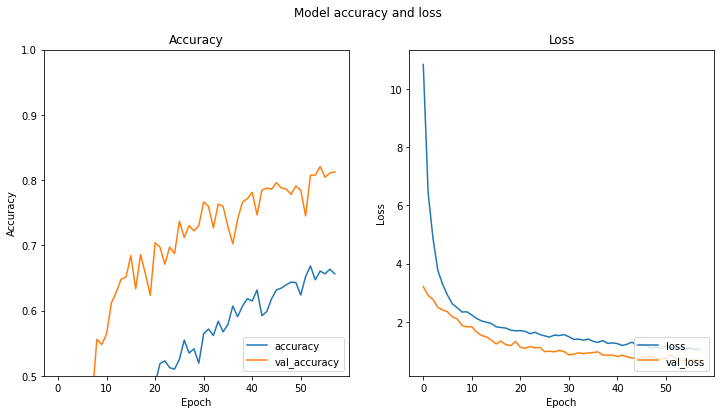

In [67]:
model_no_drop, history_no_drop, params_no_drop = create_and_solve_model(isDropout=False)

print("No dropouts:")
res = print_update_test_acc(model_no_drop, best_model)
if res:
    best_model = model_no_drop
    best_model_history = history_no_drop
    best_model_params = params_no_drop

plot_model_accuracy(history_no_drop.history)
print("\n")

for drop in [0.1, 0.4, 0.8]:
    par = {**best_model_params, **{"drop_1": drop, "drop_2": drop}}

    model_drop, history_drop, params_drop = create_and_solve_model(**par)

    print(f"Model with dropout rates: {drop}")
    res = print_update_test_acc(model_drop, best_model)
    if res:
        best_model = model_drop
        best_model_history = history_drop
        best_model_params = params_drop
    plot_model_accuracy(history_drop.history)
    print("\n")


<center><h3>Task 5.</h3></center>

With batch normalization:
19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 163ms/epoch - 9ms/step
Test accuracy: 91.612%



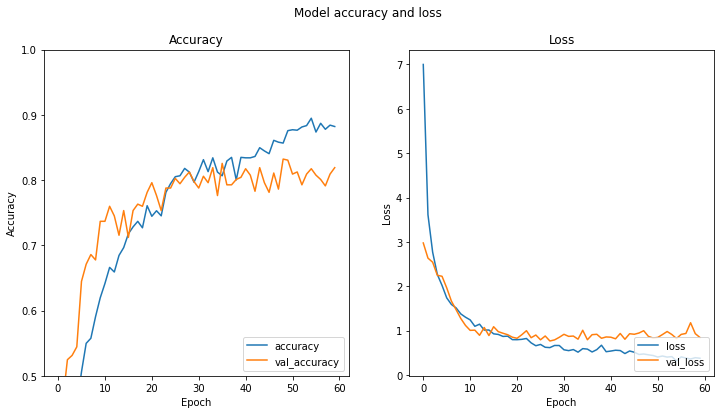



No batch normalization:
19/19 - 0s - loss: 0.9443 - accuracy: 0.8010 - 165ms/epoch - 9ms/step
Test accuracy: 80.099%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 192ms/epoch - 10ms/step


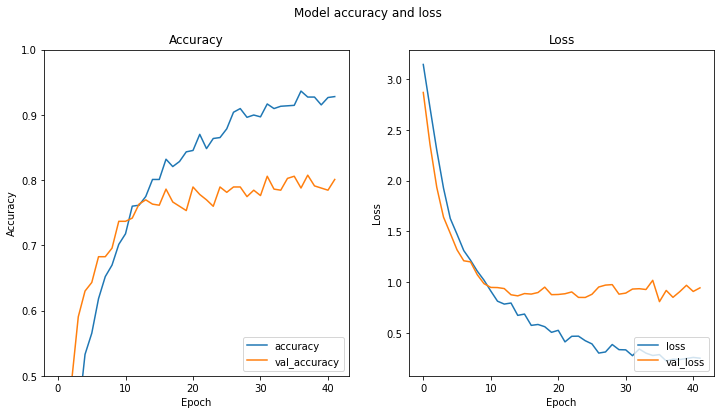

In [69]:
par = {**best_model_params, **{"isBatchNormalization": False}}

model_no_batch, history_no_batch, params_no_batch = create_and_solve_model(**par)

print("With batch normalization:")
print_update_test_acc(model)
plot_model_accuracy(history)
print("\n")

print("No batch normalization:")
res = print_update_test_acc(model_no_batch, best_model)
if res:
    best_model = model_no_batch
    best_model_history = history_no_batch
    best_model_params = params_no_batch
plot_model_accuracy(history_no_batch.history)
print("\n")


<center><h3>Task 7.</h3></center>

With ReLU activation:
19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 167ms/epoch - 9ms/step
Test accuracy: 91.612%



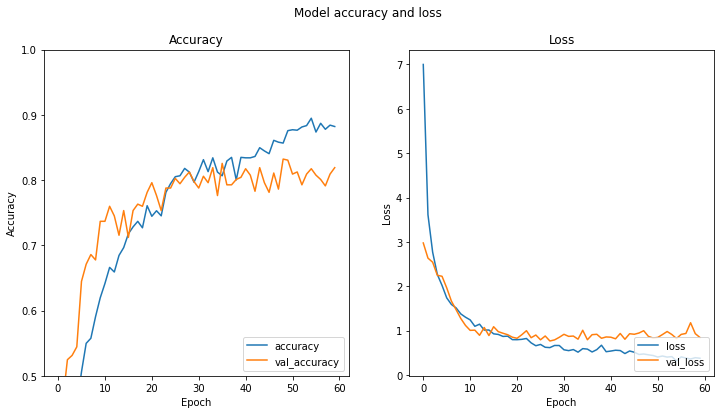



With tanh activation:
19/19 - 0s - loss: 1.2737 - accuracy: 0.7697 - 176ms/epoch - 9ms/step
Test accuracy: 76.974%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 159ms/epoch - 8ms/step


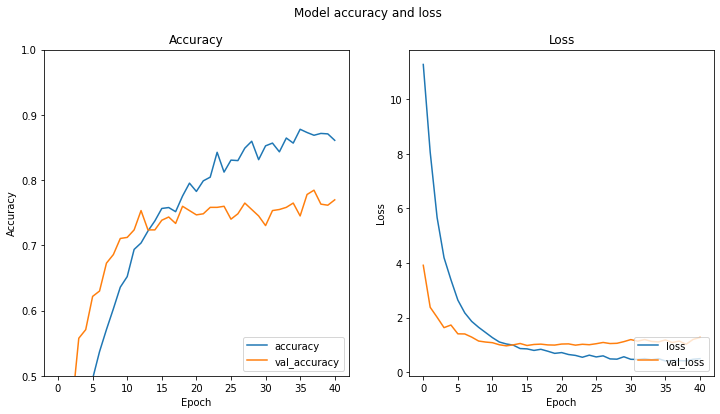



With sigmoid activation:
19/19 - 0s - loss: 1.3069 - accuracy: 0.7286 - 164ms/epoch - 9ms/step
Test accuracy: 72.862%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 159ms/epoch - 8ms/step


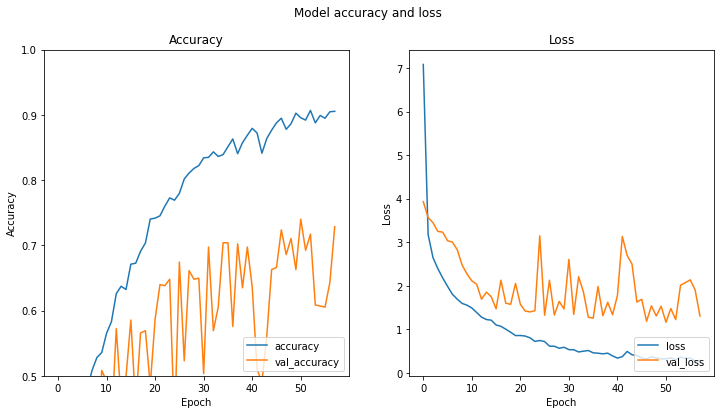



With leaky ReLU activation:
19/19 - 0s - loss: 0.9004 - accuracy: 0.7780 - 178ms/epoch - 9ms/step
Test accuracy: 77.796%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 160ms/epoch - 8ms/step


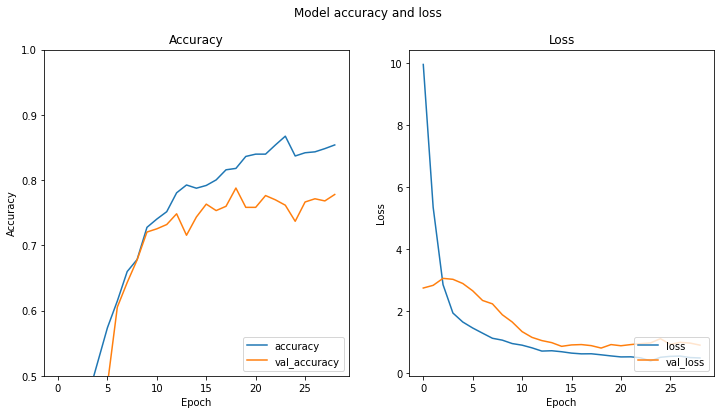

In [70]:
print("With ReLU activation:")
print_update_test_acc(model)
plot_model_accuracy(history)
print("\n")

par = {**best_model_params, **{"activation": "tanh"}}
model_tanh, history_tanh, params_tanh = create_and_solve_model(**par)
print("With tanh activation:")
res = print_update_test_acc(model_tanh, best_model)
if res:
    best_model = model_tanh
    best_model_history = history_tanh
    best_model_params = params_tanh
plot_model_accuracy(history_tanh.history)
print("\n")

par = {**best_model_params, **{"activation": "sigmoid"}}
model_sigmoid, history_sigmoid, params_sigmoid = create_and_solve_model(**par)
print("With sigmoid activation:")
res = print_update_test_acc(model_sigmoid, best_model)
if res:
    best_model = model_sigmoid
    best_model_history = history_sigmoid
    best_model_params = params_sigmoid
plot_model_accuracy(history_sigmoid.history)
print("\n")

par = {**best_model_params, **{"activation": "leaky_relu"}}
model_leaky, history_leaky, params_relu = create_and_solve_model(**par)
print("With leaky ReLU activation:")
res = print_update_test_acc(model_leaky, best_model)
if res:
    best_model = model_leaky
    best_model_history = history_leaky
    best_model_params = params_relu
plot_model_accuracy(history_leaky.history)
print("\n")

<center><h3>Task 8.</h3></center>

With MaxPool2D:
19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 164ms/epoch - 9ms/step
Test accuracy: 91.612%



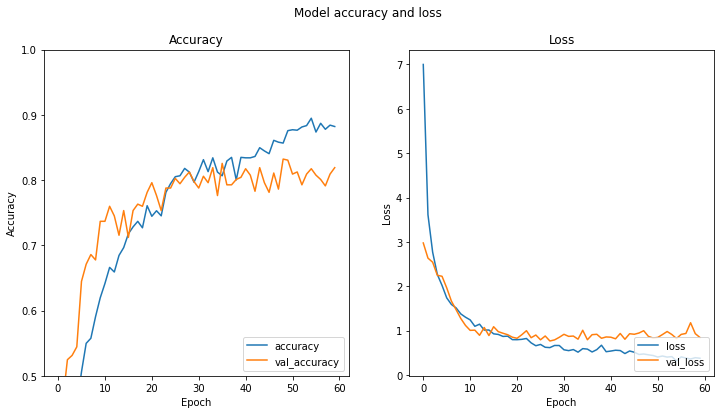



With AveragePooling2D:
19/19 - 0s - loss: 1.0537 - accuracy: 0.7911 - 218ms/epoch - 11ms/step
Test accuracy: 79.112%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 183ms/epoch - 10ms/step


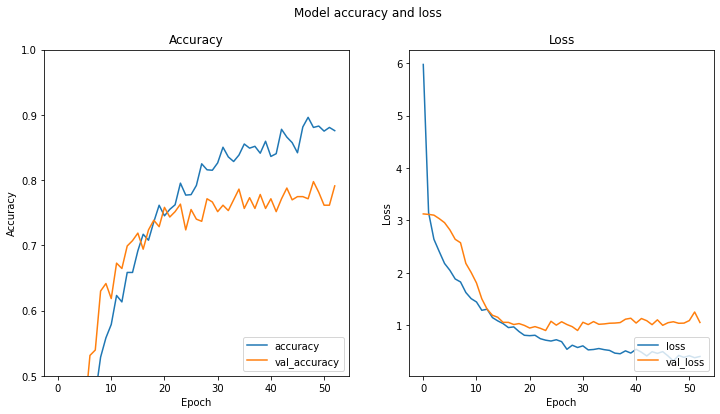

In [71]:
# Code
print("With MaxPool2D:")
print_update_test_acc(model)
plot_model_accuracy(history)
print("\n")

par = {**best_model_params, **{"pooling": layers.AveragePooling2D}}
model_AveragePooling2D, history_AveragePooling2D, params_AveragePooling2D = create_and_solve_model(**par)
print("With AveragePooling2D:")
res = print_update_test_acc(model_AveragePooling2D, best_model)
if res:
    best_model = model_AveragePooling2D
    best_model_history = history_AveragePooling2D
    best_model_params = params_AveragePooling2D
plot_model_accuracy(history_AveragePooling2D.history)
print("\n")

<center><h3>Task 9.</h3></center>

With 2 convolutional layers:
19/19 - 0s - loss: 0.8955 - accuracy: 0.8026 - 163ms/epoch - 9ms/step
Test accuracy: 80.263%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 165ms/epoch - 9ms/step


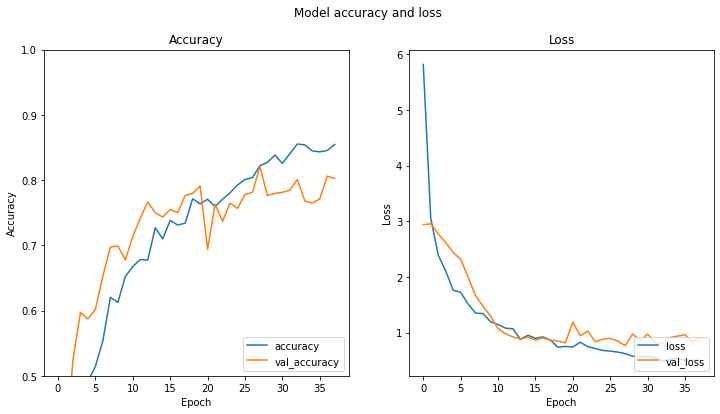



With 3 convolutional layers:
19/19 - 0s - loss: 0.8452 - accuracy: 0.8010 - 220ms/epoch - 12ms/step
Test accuracy: 80.099%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 185ms/epoch - 10ms/step


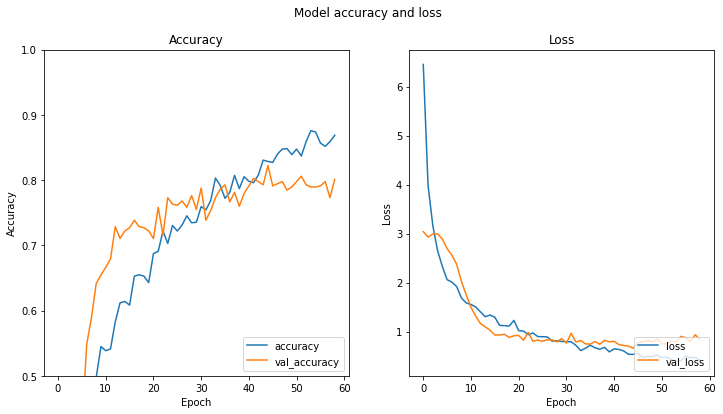



With 4 convolutional layers:
19/19 - 0s - loss: 1.0998 - accuracy: 0.7155 - 173ms/epoch - 9ms/step
Test accuracy: 71.546%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 191ms/epoch - 10ms/step


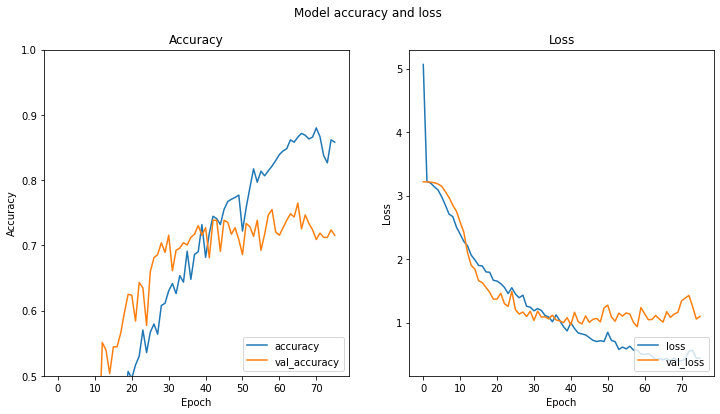

In [72]:
for no_layers in range(2, 5):
    par = {**best_model_params, **{"no_conv_layers": no_layers}}
    model_n, history_n, params_n = create_and_solve_model(**par)
    
    print(f"With {no_layers} convolutional layers:")
    res = print_update_test_acc(model_n, best_model)
    if res:
        best_model = model_n
        best_model_history = history_n
        best_model_params = params_n
    plot_model_accuracy(history_n.history)
    print("\n")

<center><h3>Task 11.</h3></center>

With batch size 1:
19/19 - 0s - loss: 1.0921 - accuracy: 0.7516 - 273ms/epoch - 14ms/step
Test accuracy: 75.164%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 161ms/epoch - 8ms/step


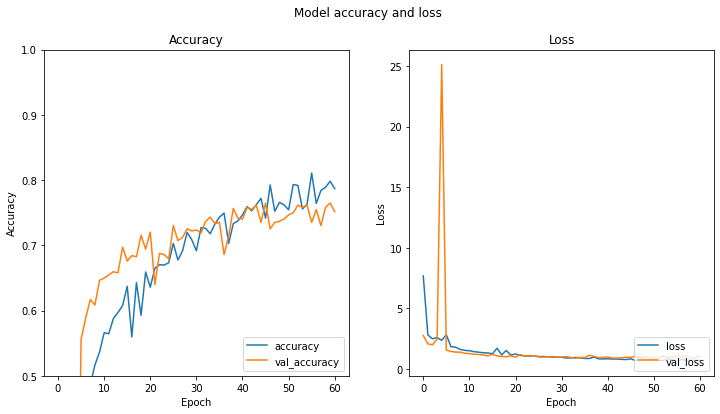



With batch size 8:
19/19 - 0s - loss: 0.6911 - accuracy: 0.8092 - 235ms/epoch - 12ms/step
Test accuracy: 80.921%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 155ms/epoch - 8ms/step


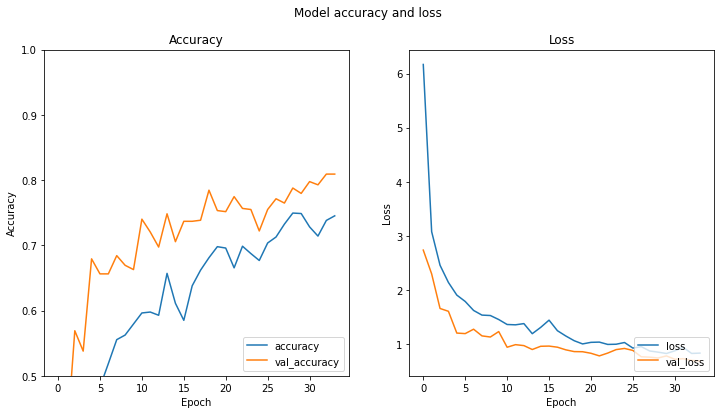



With batch size 64:
19/19 - 0s - loss: 0.8740 - accuracy: 0.7993 - 242ms/epoch - 13ms/step
Test accuracy: 79.934%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 159ms/epoch - 8ms/step


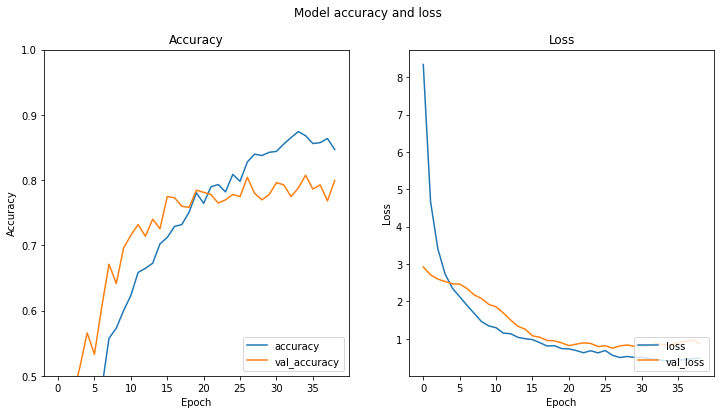



With batch size 128:
19/19 - 0s - loss: 0.7946 - accuracy: 0.7845 - 254ms/epoch - 13ms/step
Test accuracy: 78.454%

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 175ms/epoch - 9ms/step


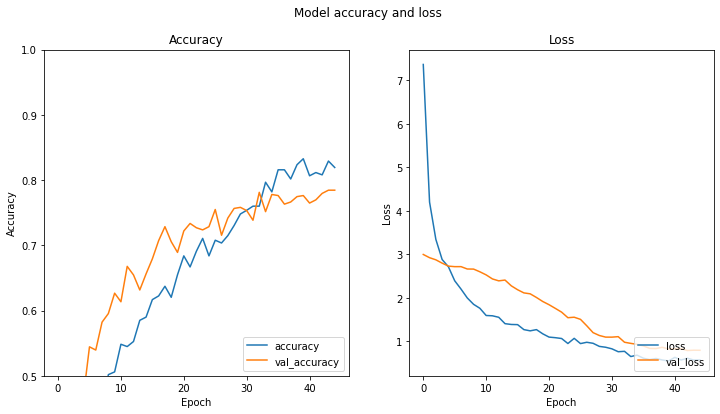

In [73]:
for batch_size in [1, 8, 64, 128]:
    par = {**best_model_params, **{"batch_size": batch_size}}
    model_batch, history_batch, params_batch = create_and_solve_model(**par)
    
    print(f"With batch size {batch_size}:")
    res = print_update_test_acc(model_batch, best_model)
    if res:
        best_model = model_batch
        best_model_history = history_batch
        best_model_params = params_batch
    plot_model_accuracy(history_batch.history)
    print("\n")

# Final results - best model:

In [78]:
best_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 64)      

In [74]:
best_model_params

{'isDropout': True,
 'drop_1': 0.75,
 'drop_2': 0.65,
 'activation': 'relu',
 'isBatchNormalization': True,
 'pooling': keras.layers.pooling.MaxPooling2D,
 'no_conv_layers': 2,
 'batch_size': 32}

19/19 - 0s - loss: 0.3710 - accuracy: 0.9161 - 189ms/epoch - 10ms/step
Test accuracy: 91.612%

Class 0:	Precision: 0.96      Recall: 1.0       F-score: 0.98      
Class 1:	Precision: 1.0       Recall: 1.0       F-score: 1.0       
Class 2:	Precision: 0.889     Recall: 1.0       F-score: 0.941     
Class 3:	Precision: 0.885     Recall: 0.958     F-score: 0.92      
Class 4:	Precision: 0.941     Recall: 0.667     F-score: 0.78      
Class 5:	Precision: 0.952     Recall: 0.833     F-score: 0.889     
Class 6:	Precision: 0.821     Recall: 0.92      F-score: 0.868     
Class 7:	Precision: 0.958     Recall: 0.92      F-score: 0.939     
Class 8:	Precision: 0.958     Recall: 0.92      F-score: 0.939     
Class 9:	Precision: 1.0       Recall: 1.0       F-score: 1.0       
Class 10:	Precision: 0.84      Recall: 0.875     F-score: 0.857     
Class 11:	Precision: 1.0       Recall: 0.875     F-score: 0.933     
Class 12:	Precision: 1.0       Recall: 0.84      F-score: 0.913     
Class 13:	Precisio

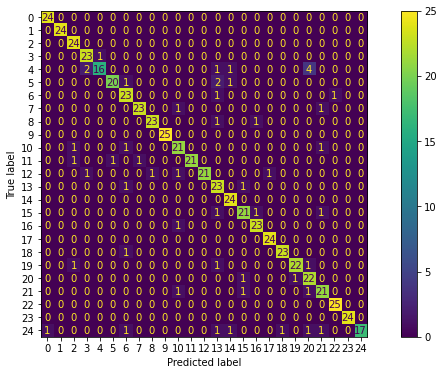

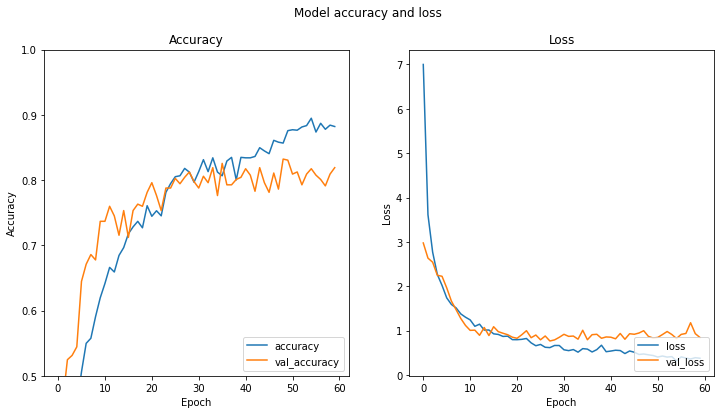

In [77]:
print_update_test_acc(best_model)
display_confusion_matrix(best_model)
plot_model_accuracy(best_model_history)

#### As we can see our best model is in fact our original model. It has pretty high test accuracy of 91%. Summary of this model was already presented at the end of part 1.